In [1]:
import modules
import torchvision.transforms as T
import torch
import ast

dict_keys(['multiprocessing', 'path_pretrained_models', 'execute_code', 'dataset', 'gpt', 'save', 'save_new_results', 'results_dir', 'use_cache', 'clear_cache', 'use_cached_codex', 'cached_codex_path', 'log_every', 'wandb', 'blip_half_precision', 'blip_v2_model_type', 'use_fixed_code', 'fixed_code_file'])
./prompts/base_prompt.txt


In [2]:
blip = modules.BLIPModel(gpu_number=0, half_precision=True)
siglip = modules.SiglipModel(gpu_number=1)
gpt = modules.GPTModel(gpu_number=1)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
class Answerer():
    def __init__(self, caption_model, vqa_model, llm):
        self.caption_model = caption_model
        self.vqa_model = vqa_model
        self.llm = llm

    # @staticmethod
    def construct_prompt(self, question, choices, video_info):
        with open('prompts/base_prompt.txt', 'r') as f:
            prompt = f.read()
        prompt = prompt.replace('insert_question', question)
        prompt = prompt.replace('insert_choices', str(choices))
        
        summary = ''
        for frame_number in sorted(video_info.caption_memory):
            summary += f'- Frame {frame_number}: {video_info.caption_memory[frame_number]}'
            if frame_number in video_info.vqa_memory:
                summary += f', {video_info.vqa_memory[frame_number]}'
            summary += '\n'
        prompt = prompt.replace('insert_summary', summary)
        return prompt
    

    def query_caption(self, frame_number: int, video_info):
        frame = video_info[frame_number]
        caption = self.caption_model.caption(image=frame)
        return caption

    def query_VQA(self, question: str, frame_number: int, video_info):
        frame = video_info[frame_number]
        answer = self.vqa_model.qa(image=frame, question=question)
        return answer

    def select_frame():
        pass

    def get_answer(self, question, subquestion, choices, video_info, LIMIT=10):
        """Main functionality for retrieving an answer to a question."""
        while LIMIT > 0:
            print(f'Iteration: {10 - LIMIT}')
            LIMIT -= 1
            prompt = self.construct_prompt(question, choices, video_info)
            print(prompt)
            response = self.llm.call_llm(prompt)
            print(response)
            parts = response.split('<explanation>')
            explanation = parts[0]
            args = ast.literal_eval(parts[1])
            
            label = args[0]
            number = args[1]
            
            video_info.explanations.append(explanation)
            if label == 'done':
                # number is index of answer choice
                return number
            elif label == 'before':
                # need to add in logic that will look thru dictionary for the right split x + y / 2
                frame_numbers = sorted(video_info.caption_memory.keys())
                for i, curr_frame_number in enumerate(frame_numbers):
                    if curr_frame_number == number:
                        prev_frame_number = frame_numbers[i - 1]
                        break
                new_frame_number = int((prev_frame_number + curr_frame_number) / 2)
            elif label == 'after':
                # need to add in logic that will look thru dictionary for the right split x + y / 2
                frame_numbers = sorted(video_info.caption_memory.keys())
                for i, curr_frame_number in enumerate(frame_numbers):
                    if curr_frame_number == number:
                        next_frame_number = frame_numbers[i + 1]
                        break
                new_frame_number = int((curr_frame_number + next_frame_number) / 2)
            
            caption = self.query_caption(new_frame_number, video_info)[0]
            video_info.caption_memory[new_frame_number] = caption
            
            # TODO: remove subquestion out of here?
            vqa_answer = self.query_VQA(subquestion, new_frame_number, video_info)[0]
            video_info.vqa_memory[new_frame_number] = vqa_answer
        return


In [4]:
answerer = Answerer(caption_model=blip, vqa_model=blip, llm=gpt)

In [5]:
from vidutils import VideoInfo
from utils import get_video

  deprecate(



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
cuda cuda


In [27]:
video_id = 4825249972
question = "what did the brown dog do before it started chasing the cat"
options = ['climbing over it', 'lying down', 'jump on the sofa and bark', 'sit and watch', 'walk back']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

In [28]:
images = torch.stack([video[i] for i in range(0, video.shape[0], 10)])
video_info = VideoInfo(images=images)
video_info.length

93

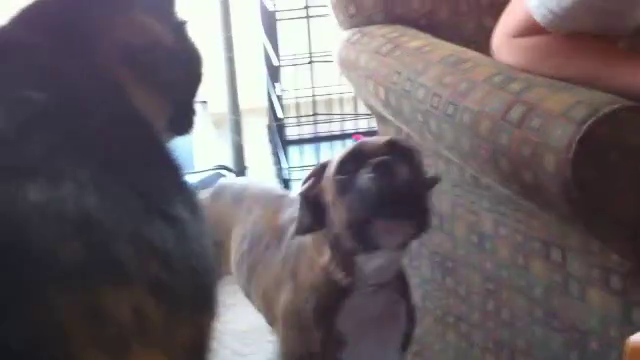

In [40]:
transform = T.ToPILImage()
image = transform(video[518])
image

In [29]:
subquestion = 'what did the brown dog do'

In [30]:
for i in (0, 52, 92):
    video_info.caption_memory[i] = answerer.query_caption(i, video_info)[0]
    video_info.vqa_memory[i] = answerer.query_VQA(frame_number=i, question=subquestion, video_info=video_info)[0]

In [17]:
answerer.query_VQA(subquestion, 52, video_info)

['jumped on the couch']

In [31]:
video_info.vqa_memory

{0: 'he jumped up', 52: 'he jumped', 92: 'jumped on the couch'}

In [32]:
answerer.get_answer(question=question, subquestion=subquestion, choices=options, video_info=video_info)

Iteration: 0
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation, followed by the token <explanation> to end the explanation.
Keep explanations concise and to the point. Then, in a tuple, either state
'done' followed by the index of the answer choice, 'before' and the existing
frame number to look before, or 'after' and the existing frame to look after.

For frame 0, you can only look after it. For the last frame number, you can only
look before it.


### Examples ###
Question: what did the girl do before eating the ice cream
Choices: ['read a book', 'watch television', 'wipe her hands', 'lie down', 'sleep']

Summary:
- Frame 0: a girl in the living room
- Frame 10: a girl eating ice cream
- Frame 25: a girl in the kitchen

Explana

INFO - 2023-12-28 07:27:42,538 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The brown dog jumped on the couch before it started chasing the cat. We have enough information to choose an answer choice.
<explanation>
('done', 2)


2

In [6]:
video_id = 7499375636
question = "what did the man in black at the back do before the man with black and green helmet drove away?"
options = ['looking at them', 'step back', 'adjusting helmet', 'driving off', 'raise his hand out the window']
# correct answer: 1
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

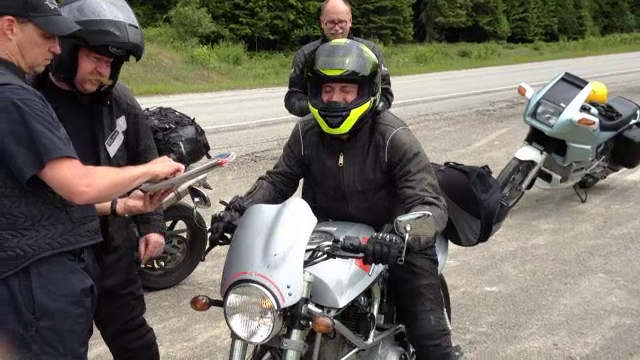

In [7]:
transform = T.ToPILImage()
image = transform(video[58])
image

In [35]:
images = torch.stack([video[i] for i in range(0, video.shape[0], 10)])
video_info = VideoInfo(images=images)

for i in (0, 58, 160):
    video_info.caption_memory[i] = answerer.query_caption(i, video_info)[0]
    video_info.vqa_memory[i] = answerer.query_VQA(frame_number=i, question=subquestion, video_info=video_info)[0]

subquestion = 'what did the man in black at the back do'
video_info.vqa_memory

{0: 'he jumped on the motorcycle',
 58: 'he jumped off the bike',
 160: 'he jumped in the water'}

In [39]:
answerer.get_answer(question=question, subquestion=subquestion, choices=options, video_info=video_info)

Iteration: 0
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. Then, in a tuple, either state 'done' followed by the
index of the answer choice, 'before' and the existing frame number to look
before, or 'after' and the existing frame to look after.

For frame 0, you can only look after it. For the last frame number, you can only
look before it.


### Examples ###
Question: what did the girl do before eating the ice cream
Choices: ['read a book', 'watch television', 'wipe her hands', 'lie down', 'sleep']

Summary:
- Frame 0: a girl in the living room
- Frame 10: a girl eating

INFO - 2023-12-28 07:46:12,379 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is not enough information to determine what the man in black at the back did before the man with the black and green helmet drove away. The captions only provide information about the man jumping on and off the motorcycle, but not about the actions of the man in black at the back. We need to look before frame 58.
<explanation>
('before', 58)
Iteration: 1
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. Then, in a tuple, either state 'done' followed by the
index of the answer choice, 'before' and the existing frame number to look
before, or 'after' and the existing fra

INFO - 2023-12-28 07:46:20,628 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is not enough information to determine what the man in black at the back was doing before the man with the black and green helmet drove away. The captions only provide information about various actions, such as jumping on the motorcycle, being a guide, reading a map, riding a motorcycle, and jumping off the bike. None of these actions directly indicate what the man in black at the back was doing before the other man drove away. We need to look before frame 58 for more context.
<explanation>
('before', 58)
Iteration: 2
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. T

INFO - 2023-12-28 07:46:27,783 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is no mention of the man in black at the back in any of the captions. We do not have enough information to determine what he did before the man with the black and green helmet drove away. We need to look before frame 58.
<explanation>
('before', 58)
Iteration: 3
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. Then, in a tuple, either state 'done' followed by the
index of the answer choice, 'before' and the existing frame number to look
before, or 'after' and the existing frame to look after.

For frame 0, you can only look after it. For the last frame number, you can

INFO - 2023-12-28 07:46:35,936 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is not enough information to determine what the man in black at the back did before the man with black and green helmet drove away. We have information about what the man in black at the back did in frames 0, 29, 43, 50, 54, 58, and 160, but none of them provide information about his actions before the man with the black and green helmet drove away. We need to look before frame 54.
<explanation>
('before', 54)
Iteration: 4
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. Then, in a tuple, either state 'done' followed by the
index of the answer choice, 'before' and the

INFO - 2023-12-28 07:46:43,252 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is not enough information to determine what the man in black at the back did before the man with the black and green helmet drove away. Although there are multiple frames showing actions of different people, none of the frames explicitly show what the man in black at the back did before the other man drove away. We need more context to answer the question. We should look before frame 58.
<explanation>
('before', 58)
Iteration: 5
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. Then, in a tuple, either state 'done' followed by the
index of the answer choice, 'before' a

INFO - 2023-12-28 07:46:50,623 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is not enough information to determine what the "man in black at the back" did before the "man with black and green helmet" drove away. The frames provided do not give any specific actions or interactions between the two individuals. We need to look before frame 56 for more context.

<explanation>
('before', 56)
Iteration: 6
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. Then, in a tuple, either state 'done' followed by the
index of the answer choice, 'before' and the existing frame number to look
before, or 'after' and the existing frame to look after.

For frame 0

INFO - 2023-12-28 07:46:58,463 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is not enough information to determine what the man in black at the back did before the man with the black and green helmet drove away. We have descriptions of various actions and movements of different people, but none specifically mention the actions of the man in black at the back before the other man drove away. We need to look before frame 56 to gather more context.
<explanation>
('before', 56)
Iteration: 7
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. Then, in a tuple, either state 'done' followed by the
index of the answer choice, 'before' and the existing f

INFO - 2023-12-28 07:47:06,447 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is not enough information to determine what the man in black at the back
did before the man with black and green helmet drove away. The captions only
provide information about the actions of the man with the black and green helmet,
but we do not have any caption specifically mentioning the man in black at the
back. We need to look before frame 54 to gather more information.
<explanation>
('before', 54)
Iteration: 8
You are a machine that answers a question about videos. You will answer a
question based on captions of events that occurred. You will choose the correct
answer choice if there is enough information. Otherwise, you will choose an
existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information,
followed by the token <explanation> to end the explanation.  Keep explanations
concise and to the point. Then, in a tuple, either state 'done' followed by the
index of the answer choice, 'before' and the existin

INFO - 2023-12-28 07:47:14,315 - _client - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There is enough information in the captions to determine that the man in black at the back did not do any of the actions listed in the answer choices before the man with the black and green helmet drove away. The captions do not provide any information about the actions of the man in black at the back before the other man drove away. 
<explanation>
('done', 0)


0

In [40]:
video_info.explanations

['The man in black at the back jumped on the motorcycle before the man with the black and green helmet drove away. We have enough information to choose an answer choice.\n',
 'The man in black at the back jumped on the motorcycle before the man with the black and green helmet drove away. We do not have enough context to know what the man in black at the back was doing among the answer choices. We need to look before frame 58.\n',
 'The man in black at the back jumped on the motorcycle before the man with the black and green helmet drove away. We have enough information to choose an answer choice.\n',
 'There is not enough information to determine what the man in black at the back did before the man with the black and green helmet drove away. The captions only provide information about the man jumping on and off the motorcycle, but not about the actions of the man in black at the back. We need to look before frame 58.\n',
 'There is not enough information to determine what the man in bl

In [41]:
video_info.caption_memory

{0: 'a group of people on motorcycles',
 58: 'a man riding a motorcycle on the road',
 160: 'a road next to a lake and mountains',
 29: 'a group of people standing next to motorcycles',
 43: 'a group of people on motorcycles',
 50: 'a group of people on motorcycles',
 54: 'a man on a motorcycle wearing a helmet',
 52: 'a man on a motorcycle',
 56: 'a man riding a motorcycle on the road',
 55: 'a man on a motorcycle wearing a helmet',
 53: 'a group of people riding motorcycles on the road'}

In [42]:
video_info.vqa_memory

{0: 'he jumped on the motorcycle',
 58: 'he jumped off the bike',
 160: 'he jumped in the water',
 29: 'he was a guide',
 43: 'read a map',
 50: 'ride his motorcycle',
 54: 'ride his motorcycle',
 52: 'he was sitting on his motorcycle',
 56: 'he was riding his motorcycle',
 55: 'ride his motorcycle',
 53: 'ride his motorcycle'}